# Protein Secondary Structure Prediction Analysis

This notebook evaluates the models for this project and tests them against the technical requirements (as provided in the problem statement).

## 1. Imports & Setup <a id='Imports'></a>

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm.notebook import tqdm
import time
import os
from torch.utils.data import DataLoader


In [ ]:
import sys, os
from pathlib import Path

# Detect the repo root (parent of 'notebooks')
repo_root = Path(__file__).resolve().parent.parent if '__file__' in globals() else Path(os.getcwd()).parent

# Add repo root to sys.path so imports work
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

# Change working directory to repo root so relative paths work (data/, checkpoints/, etc.)
os.chdir(repo_root)
print(f"Working directory set to: {os.getcwd()}")


Working directory set to: c:\_repos\Summer-Siege-ML-01


In [3]:
from config import config
from models.bilstm import BiLSTM_Model
from eval import get_model_type, load_checkpoint

## 2. Evaluation

In [4]:
def evaluate_model(ckpt_path, device = config['device']):
    model_type = get_model_type(ckpt_path)

    print(f"Loading checkpoint: {ckpt_path}")

    state_dict, arch = load_checkpoint(ckpt_path, model_type)

    model = BiLSTM_Model(
        embedding_dim=arch["embedding_dim"] if not ("esm" in str(ckpt_path)) else 320,
        hidden_dim=arch["hidden_dim"],
        num_layers=arch["num_layers"],
        dropout_rate=arch["dropout_rate"],
        use_pretrained_embeddings=("esm" in str(ckpt_path)),
    ).to(device)

    missing, unexpected = model.load_state_dict(state_dict, strict=False) # missing/unexpected likely for older checkpoints
    if missing: print(f"Warning: Missing keys: {missing}")
    if unexpected: print(f"Warning: Unexpected keys: {unexpected}")

    model.eval()
    print(f"Model loaded successfully with architecture: ")
    print(model)
    
    if model_type == "esm":
        import datasets.dataset_esm
        dataset = datasets.dataset_esm.ESM_Embedding_Dataset()
    else:
        import datasets.dataset_bilstm
        dataset = datasets.dataset_bilstm.PrepareCB513()

    loader = DataLoader(dataset, batch_size=config[model_type]["batch_size"], shuffle=False)
    
    start_time = time.time()
    
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for xb, yb in tqdm(loader, desc="Evaluating", unit="batch"):
            xb, yb = xb.to(device), yb.to(device)
            output = model(xb)
            _, preds = torch.max(output, 1)
            
            true_labels.extend(yb.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())
    
    eval_time = time.time() - start_time

    print(f"Evaluation time: {eval_time:.2f}s\n")
    
    report = classification_report(
        true_labels, pred_labels, 
        target_names=["H", "E", "C"],
        output_dict=True
    )
    cm = confusion_matrix(true_labels, pred_labels)
    
    return {
        "model_type": model_type,
        "accuracy": accuracy_score(true_labels, pred_labels),
        "report": report,
        "confusion_matrix": cm,
        "evaluation_time": eval_time,
        "samples": len(true_labels)
    }

In [5]:
print(f"Using device: {config['device']}")
results = {}
for model_type in ["bilstm", "esm"]:
    try:
        ckpt_dir = Path("checkpoints")
        matching_ckpts = [p for p in ckpt_dir.glob(f"{model_type}_*.pt")]
        if not matching_ckpts:
            raise FileNotFoundError(f"No checkpoints found for '{model_type}' in '{ckpt_dir}'.")
        ckpt_path = max(matching_ckpts, key=os.path.getmtime)
        results[model_type] = evaluate_model(ckpt_path)

    except Exception as e:
        print(f"Error evaluating {model_type}: {e}")

Using device: cuda
Loading checkpoint: checkpoints\bilstm_20250721_151454.pt
Model loaded successfully with architecture: 
BiLSTM_Model(
  (embedding): Embedding(21, 128, padding_idx=20)
  (bilstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
torch.Size([32, 31])
torch.Size([32])


Evaluating:   0%|          | 0/1313 [00:00<?, ?batch/s]

Evaluation time: 6.67s

Loading checkpoint: checkpoints\esm_20250721_102748.pt
Model loaded successfully with architecture: 
BiLSTM_Model(
  (bilstm): LSTM(320, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


Evaluating:   0%|          | 0/2625 [00:00<?, ?batch/s]

Evaluation time: 73.66s



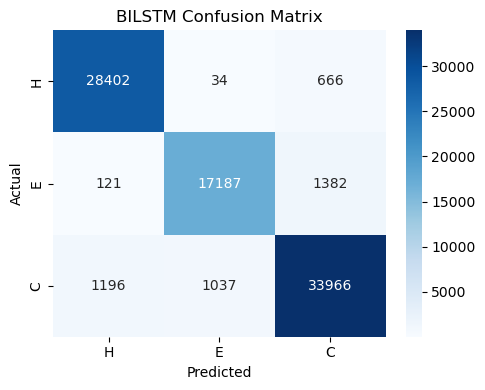

Saved bilstm_conf_matrix.png


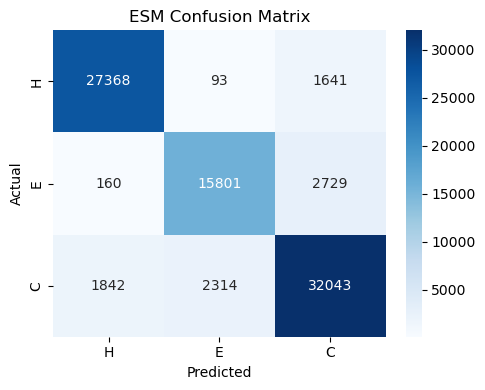

Saved esm_conf_matrix.png


In [6]:
def plot_confusion_matrices(results):
    os.makedirs("results/eval_reports", exist_ok=True)

    for model_type, data in results.items():
        fig, ax = plt.subplots(figsize=(5, 4))
        sns.heatmap(
            data["confusion_matrix"], 
            annot=True, 
            fmt="d", 
            cmap="Blues",
            xticklabels=["H", "E", "C"],
            yticklabels=["H", "E", "C"],
            ax=ax
        )
        ax.set_title(f"{model_type.upper()} Confusion Matrix")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
        plt.tight_layout()
        plt.show()
        plt.savefig(f"results/eval_reports/{model_type}_conf_matrix.png", dpi=300)
        print(f"Saved {model_type}_conf_matrix.png")
        plt.close()

plot_confusion_matrices(results)


## 5. Class-wise Performance

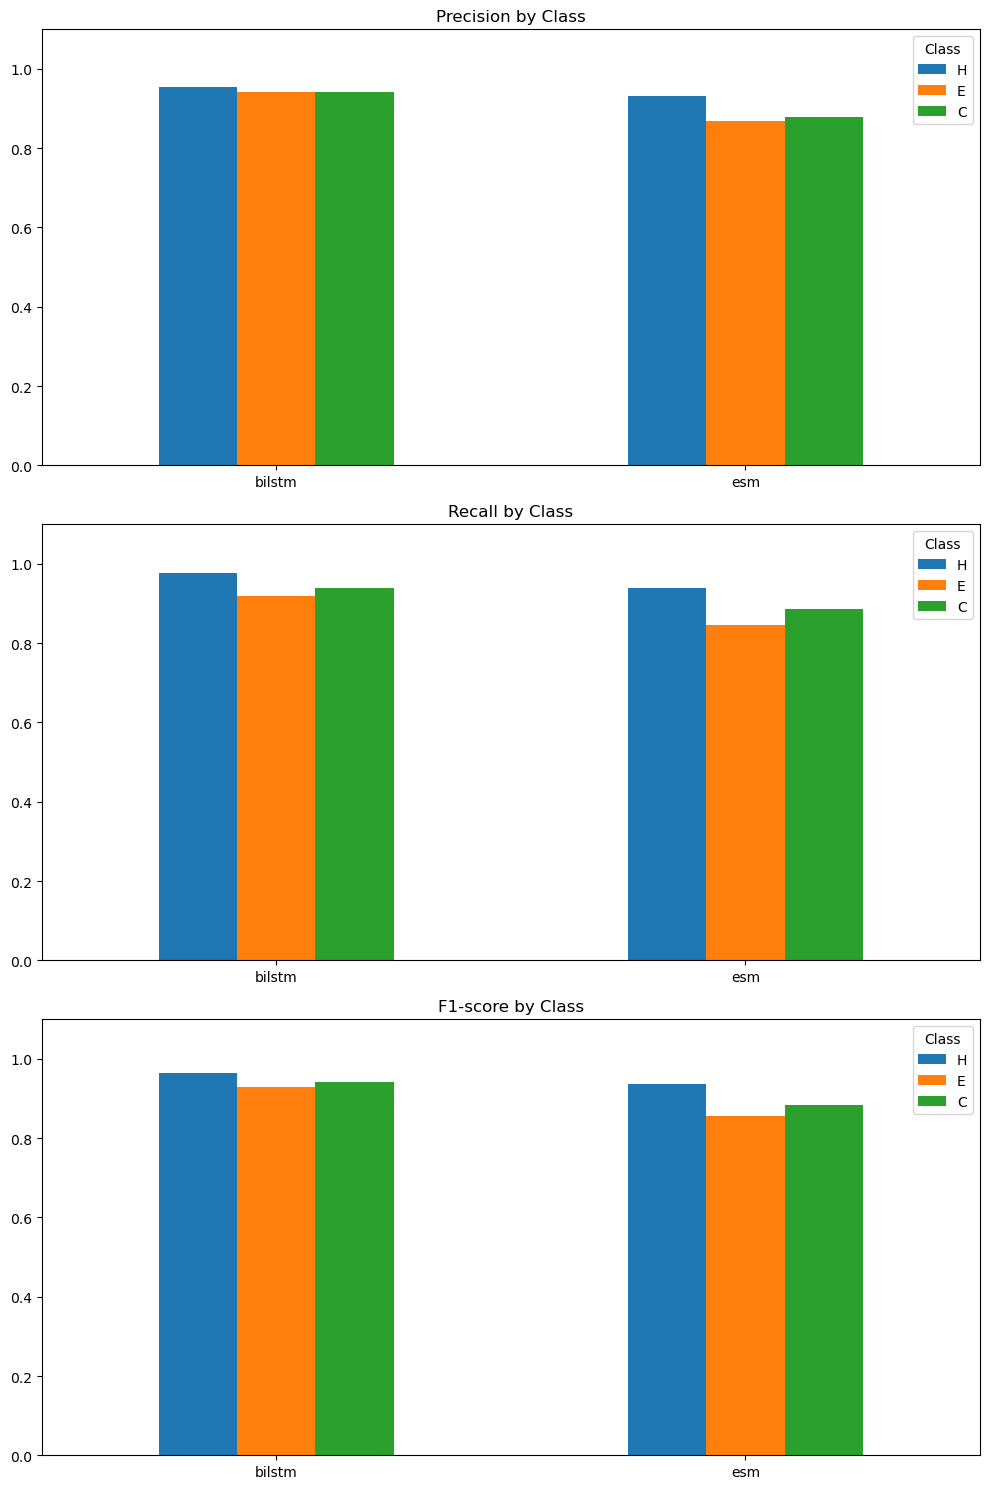

In [7]:
def plot_class_performance(results):

    metrics = ["precision", "recall", "f1-score"]
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))
    
    for i, metric in enumerate(metrics):
        df = pd.DataFrame({
            "H": [results[m]["report"]["H"][metric] for m in results],
            "E": [results[m]["report"]["E"][metric] for m in results],
            "C": [results[m]["report"]["C"][metric] for m in results]
        }, index=results.keys())
        
        df.plot(kind="bar", ax=axes[i], rot=0)
        axes[i].set_title(f"{metric.capitalize()} by Class")
        axes[i].set_ylim(0, 1.1)
        axes[i].legend(title="Class")
    
    plt.tight_layout()
    plt.show()

plot_class_performance(results)

## 6. Testing Accuracy

In [8]:
def compare_models(results):
    comparison = []
    for model_type, data in results.items():
        report = data["report"]
        comparison.append({
            "Model": model_type.upper(),
            "Q3 Accuracy": f"{data['accuracy']*100:.2f}%",
            "Helix (H) F1": f"{report['H']['f1-score']*100:.2f}%",
            "Sheet (E) F1": f"{report['E']['f1-score']*100:.2f}%",
            "Coil (C) F1": f"{report['C']['f1-score']*100:.2f}%",
            "Inference Time": f"{data['evaluation_time']:.2f}s",
            "Samples": data["samples"]
        })

    # store comparison data
    os.makedirs("results/eval_reports", exist_ok=True)
    for model_type, data in results.items():
        comparison_df = pd.DataFrame([data])
        comparison_df.to_csv(f"results/eval_reports/{model_type}_metrics.csv", index=False)

    return pd.DataFrame(comparison)

comparison_df = compare_models(results)
display(comparison_df)


,Model,Q3 Accuracy,Helix (H) F1,Sheet (E) F1,Coil (C) F1,Inference Time,Samples
0,BILSTM,94.72%,96.57%,93.03%,94.07%,6.67s,83991
1,ESM,89.55%,93.61%,85.65%,88.26%,73.66s,83991


## 7. Testing Efficiency
We will be testing both models on a protein sequence containing 1000 residues.

In [9]:

def test_efficiency(model_type, device, target_residues=1000):

    if model_type == "esm":
        from datasets.dataset_esm import ESM_Embedding_Dataset as Dataset
        model = BiLSTM_Model(use_pretrained_embeddings=True).to(device)
    else:
        from datasets.dataset_bilstm import PrepareCB513 as Dataset
        model = BiLSTM_Model(use_pretrained_embeddings=False).to(device)

    # Load model
    checkpoint_dir = Path("checkpoints")
    ckpt_path = max((p for p in checkpoint_dir.glob(f"{model_type}_*.pt")), key=os.path.getmtime)
    model.load_state_dict(torch.load(ckpt_path, map_location=device, weights_only=True), strict=False)
    model.eval()

    dataset = Dataset()
    loader = DataLoader(dataset, batch_size=1, shuffle=False)

    total_residues = 0
    timed_batches = []
    start_time = time.time()

    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            batch_residues = yb.numel()
            out = model(xb)
            total_residues += batch_residues
            if total_residues >= target_residues:
                break

    elapsed = time.time() - start_time
    print(f"Model: {model_type.upper()}")
    print(f"Time to infer {total_residues} residues: {elapsed:.3f} sec")

test_efficiency("bilstm", "cuda")
print('\n')
test_efficiency("esm", "cuda")


Model: BILSTM
Time to infer 1000 residues: 3.456 sec


Model: ESM
Time to infer 1000 residues: 2.837 sec


## 8. Testing Interpretability

To illustrate interpretability, we will be using the ESM pre-trained embeddings instead of the learnt embeddings, since the pre-trained embeddings capture richer structural information that can be meaningfully interpreted when computing gradients of surrounding residues in the window.

In [10]:
model_type = 'esm'
device = config['device']

best_model_path = f"results/hpo_runs/{model_type}/best_model.pt"
if (not os.path.exists(best_model_path)):
    print(f"Best model not found for {model_type}, loading latest checkpoint...")
    ckpt_dir = Path("checkpoints")
    matching_ckpts = [p for p in ckpt_dir.glob(f"{model_type}_*.pt")]
    if not matching_ckpts:
        raise FileNotFoundError(f"No checkpoints found for '{model_type}' in '{ckpt_dir}'.")
    ckpt_path = max(matching_ckpts, key=os.path.getmtime)
else:
    ckpt_path = best_model_path

state_dict, arch = load_checkpoint(ckpt_path, model_type)

model = BiLSTM_Model(
        hidden_dim=arch["hidden_dim"],
        num_layers=arch["num_layers"],
        dropout_rate=arch["dropout_rate"],
        use_pretrained_embeddings=config["use_pretrained_embeddings"],
        embedding_dim=arch.get("embedding_dim", 16)
    ).to(device)

missing, unexpected = model.load_state_dict(state_dict, strict=False) # likely for older checkpoints
if missing: print(f"Warning: Missing keys: {missing}")
if unexpected: print(f"Warning: Unexpected keys: {unexpected}\n")

print(f"{model_type} model loaded successfully with architecture: \n{arch}")

model.train()

if model_type == "esm":
    from datasets.dataset_esm import ESM_Embedding_Dataset as Dataset
else:
    from datasets.dataset_bilstm import PrepareCB513 as Dataset

Best model not found for esm, loading latest checkpoint...
esm model loaded successfully with architecture: 
{'window_size': 21, 'batch_size': 32, 'hidden_dim': 128, 'epochs': 30, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'patience': 2, 'num_layers': 1}


In [11]:
def compute_importance(x):
    '''
    run one sample through model, backprop, compute and return importance
    '''
    x = x.unsqueeze(0).to(device)          # [1, window_size]
    x.requires_grad_()
    out = model(x)                         # [1, 3] (logits)
    pred = out.argmax(dim=1)[0].item()
    score = out[0, pred]
    score.backward(retain_graph=True)
    imp = x.grad.abs().sum(dim=-1).squeeze().cpu().numpy()
    x.grad.zero_()                         
    return pred, imp

dataset = Dataset()
N = 500
importances = defaultdict(list)
for i in range(min(N, len(dataset))):
    x, y = dataset[i]
    pred_cls, imp = compute_importance(x)
    importances[pred_cls].append(imp)

for cls, imps in importances.items():
    print(f"Class {cls}: {len(imps)} samples") # 0: H, 1: E, 2: C
    print(f"  Mean importance: {np.mean(imps):.4f}")
    print(f"  Std importance: {np.std(imps):.4f}")
    print(f"  Min importance: {np.min(imps):.4f}")
    print(f"  Max importance: {np.max(imps):.4f}")
    print()


Class 2: 244 samples
  Mean importance: 10.7038
  Std importance: 12.1280
  Min importance: 1.4583
  Max importance: 394.1435

Class 0: 139 samples
  Mean importance: 23.3270
  Std importance: 22.6887
  Min importance: 4.3683
  Max importance: 677.1385

Class 1: 117 samples
  Mean importance: 16.3026
  Std importance: 17.1091
  Min importance: 3.0563
  Max importance: 492.0145



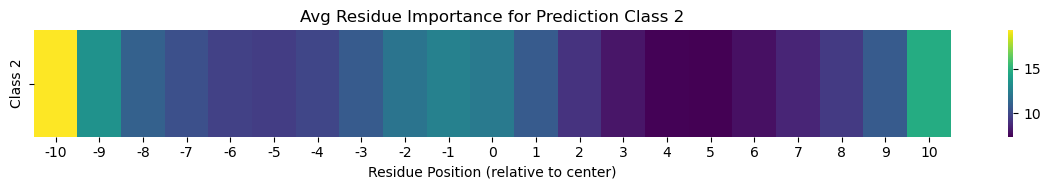

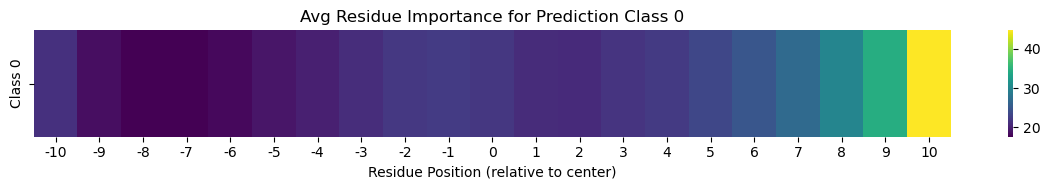

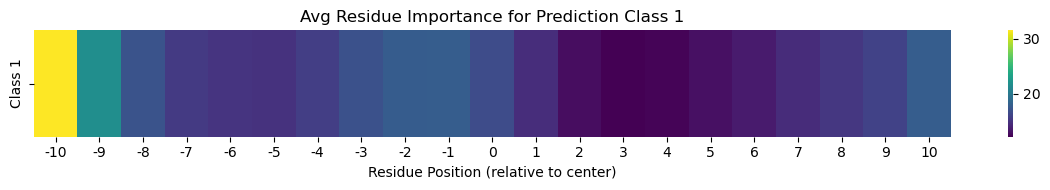

In [ ]:
avg_importance = {
    cls: np.mean(np.stack(imps, axis=0), axis=0)
    for cls, imps in importances.items()
}

for cls, imp_vec in avg_importance.items():
    plt.figure(figsize=(12, 2))
    sns.heatmap([imp_vec],
                cmap='viridis',
                cbar=True,
                xticklabels=[f"{i - (imp_vec.size//2)}" for i in range(imp_vec.size)],
                yticklabels=[f"Class {cls}"])
    plt.title(f"Avg Residue Importance for Prediction Class {cls}")
    plt.xlabel("Residue Position (relative to center)")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

### Inference from the Importance Maps  

* Importance is highly concentrated towards the window edges
* 'H' has much more importance in the right half residues
* Residues in the inner region of the left half have minimal importance for all classes
